In [1]:
#In case they are not installed already...
Pkg.add("MAT")
Pkg.add("PyPlot")

INFO: Nothing to be done
INFO: Nothing to be done


In [2]:
using MAT
using PyPlot

In [3]:
#start script
include("findnearest.jl")
include("findneighbours.jl")
include("removeedge.jl")
#include("removenode.jl")
include("gwr.jl")
include("plotgwr.jl")


rebuild (generic function with 1 method)

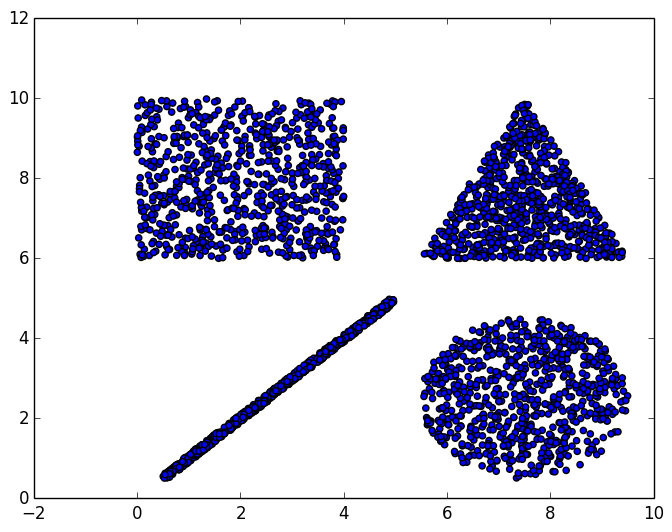

PyObject <matplotlib.collections.PathCollection object at 0x322ea0fd0>

In [4]:
#using CPUtime
file = matopen("/Users/fredericobelmonteklein/matlabprogs/gwr/share/local_uniform_2d.mat")
Data = read(file, "Data")
scatter(Data[1,:]',Data[2,:]', )

In [5]:
#Just so that I remember: function gwr(data,MAXNUMBEROFNODES)
data = Data;
MAXNUMBEROFNODES = 100;

In [6]:
#################################################
#cf parisi, 2015 and cf marsland, 2002
#based on the GNG algorithm from the guy that did the GNG algorithm for
#matlab

# some tiny differences:
# in the 2002 paper, they want to show the learning of topologies ability
# of the GWR algorithm, which is not our main goal. In this sense they have
# a function that can generate new points as pleased p(eta). This is not
# our case, we will just go through our data sequentially

# I am not taking time into account. the h(time) function is therefore
# something that yields a constant value

#the initial parameters for the algorithm:
global maxnodes, at, en, eb, h0, ab, an, tb, tn, amax, A, C
#########################################################################
#########################################################################
maxnodes = MAXNUMBEROFNODES; #maximum number of nodes/neurons in the gas
at = 0.95; #activity threshold
en = 0.006; #epsilon subscript n
eb = 0.2; #epsilon subscript b
h0 = 1;
ab = 0.95;
an = 0.95;
tb = 3.33;
tn = 3.33;
amax = 50; #greatest allowed age
#########################################################################
#########################################################################
t0 = time(); # my algorithm is not necessarily static!
STATIC = true;
RANDOMSTART = true;
################### ATTENTION STILL MISSING FIRING RATE! will have problems
################### when algorithm not static!!!!

#test some algorithm conditions:
if !(0 < en || en < eb || eb < 1)
    error("en and/or eb definitions are wrong. They are as: 0<en<eb<1.")
end
# (1)
# pick n1 and n2 from data
ni1 = 1; 
ni2 = 2; 
if RANDOMSTART
    n = randperm(size(data,2));
    ni1 = n[1];
    ni2 = n[2];
end
n1 = data[:,ni1]; n2 = data[:,ni2];

#println(strcat("Initial parameters ","n1 =  ",num2str(ni1)," n2 =  ",num2str(ni2)))

A = zeros(size(n1,1),maxnodes);
    A[:,[1,2]] = hcat(n1, n2)

# (2)
# initialize empty set C

C = spzeros(maxnodes,maxnodes); # this is a zeros sparse matrix julia style (the connection matrix).
C_age = C;

r = 3; #the first point to be added is the point 3 because we already have n1 and n2
h = zeros(1,maxnodes);#firing counter matrix
datasetsize = size(data,2);

#some variables to display the graphs
activations = [];
nodecount = [];
epoch = 1;

### SPEEDUP CHANGE
if STATIC
    hizero = hi(0)*ones(1,maxnodes);
    hszero = hs(0);
else
    timetime = 0;
end

1.0

In [7]:
DOOVER = 1;

In [8]:
function removenode(C, A, C_age, h,r) #depends only on C operates on everything

row,col = findnz(C);

maxa = maximum(row);
for i = 1:maxa
    
    if isempty(row)||maximum(row)<maxa #ok, lets try this, if the old maximum is not valid anymore stop the for loop. # I needed to add the isempty(row) because julia complains about finding the maximum of an empty array. This is likely a bug I created somewhere else, but until I find it, this will remain like this.
        break # I am assuming that this also means that all of the remaining rows and columns are zeroed
    end
    if !any(row .== i)           ################ this
        #println("removed node!")
        #has to do this to every matrix and vector
        C = clipsimmat(C,i);
        if i>size(A,2)
            println("wrong stuff going on")
        end
        A = clipA(A,i); 
        C_age = clipsimmat(C_age,i);
        h = clipvect(h,i);
        r = r-1;
        if r<1||r!=floor(r)
            error("something fishy happening. r is either zero or fractionary!");
        end
        row,col = findnz(C);
    end
   
end
return C, A, C_age, h,r

end

removenode (generic function with 1 method)

# Alternatives

In [19]:
#ALTERNATIVE CLIPSIMATT
function clipsimmat(C,i)
    a = size(C,2);
    if i>a
        error("out of bounds")
    end
    if i==1
        C[1:end-1,1:end-1] = C[2:end,2:end];
    else
        C[1:i-1,i:end-1] = C[1:i-1,i+1:end];
        C[i:end-1,1:i-1] = C[i+1:end,1:i-1];
        C[i:end-1,i:end-1] = C[i+1:end,i+1:end]; #this part has to be moved last or it will overwrite the matrix
    end
    C[:,end] = zeros(a,1);
    C[end,:] = zeros(1,a);
    return C
end

clipsimmat (generic function with 1 method)

In [20]:
a = ones(10000,10000);
tic()
a = clipsimmat(a,1)
toc()
b = [[1 2 3 4 ];[ 5 6 7 8];[9 10 11 12 ];[ 13 14 15 16]]
clipsimmat(b,3)

elapsed time: 0.

4x4 Array{Int64,2}:
  1   2   4  0
  5   6   8  0
 13  14  16  0
  0   0   0  0

605943396 seconds


In [9]:
function clipsimmat(C,i)
    if i>size(C,2)
   error("out of bounds")
end

C = C[:, 1:size(C,2) .!= i];
C = C[1:size(C,1) .!= i,:];
ZORE = zeros(size(C,1),1);
C = [C ZORE]; 
ZERO = zeros(1,size(C,2));
C = [C;ZERO];
return C
end

clipsimmat (generic function with 1 method)

In [10]:
a = ones(10000,10000);
tic()
a = clipsimmat(a,1)
toc()
b = [[1 2 3 4 ];[ 5 6 7 8];[9 10 11 12 ];[ 13 14 15 16]]
clipsimmat(b,3)

elapsed time: 1

4x4 Array{Float64,2}:
  1.0   2.0   4.0  0.0
  5.0   6.0   8.0  0.0
 13.0  14.0  16.0  0.0
  0.0   0.0   0.0  0.0

.88008271 seconds


In [23]:
#ALTERNATIVE CLIPVECT
function clipvect(V, i)
    a = size(V,2);
    if i>a
       error("out of bounds")
    end
    V[i:end-1] = V[i+1:end];
    V[end] = 0;
return V
end

clipvect (generic function with 1 method)

In [24]:
a = ones(1,100000000)
tic()
clipvect(a,1)
toc()
a = [1 2 3 4];
clipvect(a,4)

elapsed time: 0.

1x4 Array{Int64,2}:
 1  2  3  0

48733269 seconds


In [11]:
function clipvect(V, i)
if i>size(V,2)
   error("out of bounds")
end

V = V[:,1:size(V,2) .!= i];
V = [V 0];
end

clipvect (generic function with 1 method)

In [12]:
a = ones(1,100000000)
tic()
clipvect(a,1)
toc()
a = [1 2 3 4];
clipvect(a,4)

elapsed time: 2

1x4 Array{Int64,2}:
 1  2  3  0

.021493867 seconds


In [26]:
function clipA(A, i)
    a = size(A,2);
    b = size(A,1);
    if i>a
        error("out of bounds")
    end
    if i != a 
        A[:,i:end-1] = A[:,i+1:end];
    end
    A[:,end] = zeros(b,1);
    return A
end 

clipA (generic function with 1 method)

In [27]:
a = ones(10,10000000)
tic()
clipA(a,3)
toc()
a = [[1 2 3];[1 2 3];[1 2 3];[1 2 3]]
clipA(a,2)

elapsed time: 0.

4x3 Array{Int64,2}:
 1  3  0
 1  3  0
 1  3  0
 1  3  0

634280745 seconds


In [13]:
function clipA(A, i)
if i>size(A,2)
   error("out of bounds")
end
A = A[:,1:size(A,2) .!= i];
ZERO = zeros(size(A,1),1);
A = [A ZERO];
return A

end

clipA (generic function with 1 method)

In [25]:
a = ones(10,10000000)
tic()
clipA(a,3)
toc()
a = [[1 2 3];[1 2 3];[1 2 3];[1 2 3]]
clipA(a,2)

elapsed time: 0.

4x3 Array{Float64,2}:
 1.0  3.0  0.0
 1.0  3.0  0.0
 1.0  3.0  0.0
 1.0  3.0  0.0

947688916 seconds


In [28]:
tic()

for aaaaa = 1:DOOVER
for k = 1:datasetsize #step 1
	#global A
        eta = data[:,k]; # this the k-th data sample
        ws, (), s, t, () = findnearest(eta, A); #step 2 and 3
    if C[s,t]==0 #step 4
        C = spdi_bind(C,s,t);
    else
        C_age = spdi_del(C_age,s,t);
    end
    a = exp(-norm(eta-ws)); #step 5
    
    #algorithm has some issues, so here I will calculate the neighbours of
    #s
    neighbours = findneighbours(s, C);

    num_of_neighbours = size(neighbours,1);
  
    if a < at && r <= maxnodes #step 6
        wr = 0.5*(ws+eta); #too low activity, needs to create new node r
        A[:,r] = wr;
        C = spdi_bind(C,t,r);
        C = spdi_bind(C,s,r);
        C = spdi_del(C,s,t);
        r = r+1;
    else #step 7
        for j = 1:num_of_neighbours # check this for possible indexing errors
            i = neighbours[j];
            wi = A[:,i];
            A[:,i] = wi + en*h[i]*(eta-wi);
        end
        A[:,s] = ws + eb*h[s]*(eta-ws); #adjusts nearest point MORE;;; also, I need to adjust this after the for loop or the for loop would reset this!!!
    end
    #step 8 : age edges with end at s
    #first we need to find if the edges connect to s
    
    for j = 1:num_of_neighbours # check this for possible indexing errors
           i = neighbours[j];
           C_age = spdi_add(C_age,s,i);
    end
          
    #step 9: again we do it inverted, for loop first
    #### this strange check is a speedup for the case when the algorithm is static
    if STATIC # skips this if algorithm is static
        h = hizero;
        h[s] = hszero;
    else
        for i = 1:r ### since this value is the same for all I can compute it once and then make all the array have the same value...
            h[i] = hi(time); #ok, is this sloppy or what? t for the second nearest point and t for time
        end
        h[s] = hs(timetime);
        timetime = (time - t0)*1; 
    end    
   
    #step 10: check if a node has no edges and delete them
    #[C, A, C_age, h, r ] = removenode(C, A, C_age, h, r); 
    #check for old edges
    if r>2 # don't remove everything
        C, C_age  = removeedge(C, C_age);  
        C, A, C_age, h, r  = removenode(C, A, C_age, h, r);  #inverted order as it says on the algorithm to remove points faster
    end
    #activations = vcat(activations, a);
    epoch += 1;   
    
end
end
toc()

elapsed time: 2

2.136249098

.136249098 seconds


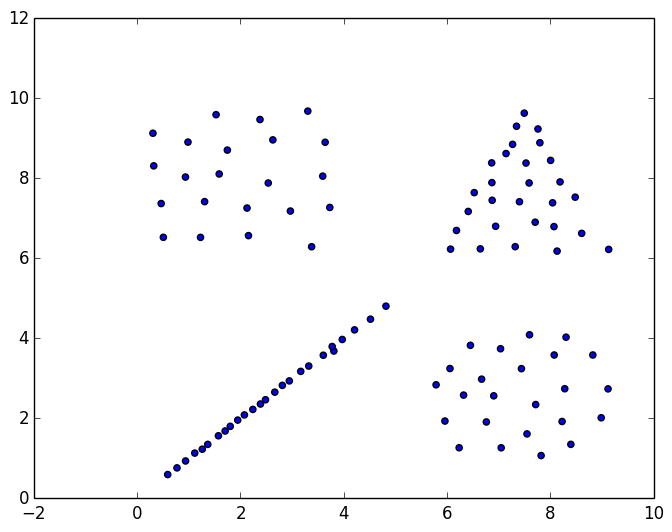

PyObject <matplotlib.collections.PathCollection object at 0x3287b9a50>

In [29]:
scatter(A[1,:]', A[2,:]')  
